In [ ]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import pulp
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

1. Récupération des données

In [2]:
N = 3
fichiers_production = ['prodA.csv', 'prodB.csv', 'prodC.csv']
fichier_demande = 'demand2050_ademe.csv'

a. Traitement des fichiers de production (prodA, prodB, prodC)

In [3]:
liste_production_series = []

print("Chargement des fichiers de production...")
for nom_fichier in fichiers_production:
    try:
        df = pd.read_csv(nom_fichier)
        # On ajoute la colonne 'Production_Elec' convertie en float
        liste_production_series.append(df['Production_Elec'].astype(float))
        print(f"  - {nom_fichier} chargé avec succès.")
    except FileNotFoundError:
        print(f"Erreur : Le fichier {nom_fichier} n'a pas été trouvé.")

if liste_production_series:
    # Concaténation en une seule DataFrame avec colonnes pour chaque production
    # On s'assure que toutes les séries ont la même longueur
    min_len = min(len(s) for s in liste_production_series)
    # Tronque toutes les séries à la même longueur
    liste_tronquee = [s[:min_len] for s in liste_production_series]
    
    # Transformation en DataFrame (colonnes = prodA, prodB, prodC)
    df_production = pd.DataFrame({
        f'prod{i+1}': serie for i, serie in enumerate(liste_tronquee)
    })
    
    # Conversion en matrice numpy
    matrice_production = df_production.to_numpy()
    print("Matrice de production créée avec succès.")
else:
    matrice_production = np.array([])
    print("Aucun fichier de production n'a pu être chargé. La matrice est vide.")


Chargement des fichiers de production...
  - prodA.csv chargé avec succès.
  - prodB.csv chargé avec succès.
  - prodC.csv chargé avec succès.
Matrice de production créée avec succès.


b. Traitement du fichier de demande (demand2050_ademe.csv)

In [4]:
print("\nChargement du fichier de demande...")
try:
    df_demande = pd.read_csv(fichier_demande, header=None)
    vecteur_demande = df_demande.iloc[:, 1].astype(float).to_numpy()

    if matrice_production.size > 0:
        n_lignes, n_colonnes = matrice_production.shape
        # Nombre d’éléments par colonne
        L = len(vecteur_demande)
        taille_colonne = int(np.ceil(L / n_colonnes))

        # Créer une matrice vide
        matrice_demande = np.zeros((n_lignes, n_colonnes))

        for i in range(n_colonnes):
            start = i * taille_colonne
            end = start + n_lignes
            # Extraire la partie correspondante et compléter si nécessaire
            partie = vecteur_demande[start:end]
            if len(partie) < n_lignes:
                # compléter avec la dernière valeur de la partie
                partie = np.concatenate([partie, np.full(n_lignes - len(partie), partie[-1])])
            matrice_demande[:, i] = partie

    else:
        matrice_demande = np.array([])
        print("La matrice de production est vide, la matrice de demande ne peut pas être alignée.")

    print("Matrice de demande créée avec succès.")

except FileNotFoundError:
    matrice_demande = np.array([])
    print(f"Erreur : Le fichier {fichier_demande} n'a pas été trouvé.")

    
print(np.shape(matrice_demande))
print(np.shape(matrice_production))
print(matrice_demande)




Chargement du fichier de demande...
Matrice de demande créée avec succès.
(2920, 3)
(2920, 3)
[[28.6900142 52.2312379 45.2468095]
 [31.2084578 46.3139339 56.6973334]
 [27.6996061 46.33277   62.0020965]
 ...
 [58.1660071 31.6128117 36.7066712]
 [56.1246215 33.0292104 33.2898536]
 [54.4065208 37.3809909 28.6056381]]


Les deux matrices sont maintenant disponibles dans les variables `matrice_production` et `matrice_demande`.

- prod : matrice où les lignes representent pour chaque heure (prodA, prodB, prodC)
- demand : matrice où les lignes representent pour chaque heure (demandA, demandB, demandC)
- qmax : capacité maximale de flux entre deux pays
- N : nombre de pays
- T : nombre de périodes

Les paramètres sur lesquels ont peut jouer sont ci-dessous

In [98]:
jour=24
semaine=24*7
mois=24*30
#Echantillon choisi : on remarque que du jour 9 au jour 10 il y aura pour certaines heures un déficit obligatoire
# -> Bonne période pour faire des tests
prod=matrice_production[9*jour:11*jour]
dem=matrice_demande[9*jour:11*jour]

T,N=np.shape(dem)
qmax =np.array([[0,50,20],[50,0,80],[20,80,0]])

print(N)
print(T)
print(qmax)

3
48
[[ 0 50 20]
 [50  0 80]
 [20 80  0]]


2. Ecriture de l'algorithme de résolution

In [83]:
import pulp
import numpy as np

def solve_flux(prod_matrix, demand_matrix, qmax_matrix):
    """
    Résout le flux optimal pour N pays et T périodes, avec PuLP.

    prod_matrix : np.array (T, N)
    demand_matrix : np.array (T, N)
    qmax_matrix : np.array (N, N), symétrique, diag = 0
    """

    T, N = prod_matrix.shape

    # Sécurité : contrôle taille qmax_matrix
    assert qmax_matrix.shape == (N, N), "qmax_matrix doit être de taille (N, N)"
    assert np.allclose(qmax_matrix, qmax_matrix.T), "qmax_matrix doit être symétrique"
    assert np.all(np.diag(qmax_matrix) == 0), "La diagonale de qmax_matrix doit être nulle"

    Q = prod_matrix - demand_matrix

    # Problème d'optimisation
    prob = pulp.LpProblem("Optimal_Flux", pulp.LpMinimize)

    # Flux inter-pays q[t,i,j]
    q = {}
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if i != j:
                    q[t, i, j] = pulp.LpVariable(
                        f"q_{t}_{i}_{j}",
                        lowBound=0,
                        upBound=float(qmax_matrix[i, j])
                    )

    # Variables r_pos et r_neg
    r_pos, r_neg = {}, {}
    for t in range(T):
        for i in range(N):
            if Q[t, i] >= 0:
                r_pos[t, i] = pulp.LpVariable(f"r_pos_{t}_{i}", lowBound=0)
                r_neg[t, i] = pulp.LpVariable(f"r_neg_{t}_{i}", lowBound=0, upBound=0)
            else:
                r_pos[t, i] = pulp.LpVariable(f"r_pos_{t}_{i}", lowBound=0, upBound=0)
                r_neg[t, i] = pulp.LpVariable(f"r_neg_{t}_{i}", lowBound=0)

    # Fonction objectif : minimiser les déficites et maximiser les restes positifs
    prob += pulp.lpSum(100*r_neg[t, i]-r_pos[t, i] for t in range(T) for i in range(N))

    # Contraintes de bilan
    for t in range(T):
        for i in range(N):
            inflow = pulp.lpSum(q[t, j, i] for j in range(N) if j != i)
            outflow = pulp.lpSum(q[t, i, j] for j in range(N) if j != i)
            prob += (
                r_pos[t, i] - r_neg[t, i]
                == prod_matrix[t, i] - demand_matrix[t, i] + 0.9 * inflow - outflow
            )

    # Résolution
    solver = pulp.PULP_CBC_CMD(msg=False)
    prob.solve(solver)

    # Extraction solutions
    q_array = np.zeros((T, N, N))
    r_pos_array = np.zeros((T, N))
    r_neg_array = np.zeros((T, N))

    for t in range(T):
        for i in range(N):
            r_pos_array[t, i] = pulp.value(r_pos[t, i])
            r_neg_array[t, i] = pulp.value(r_neg[t, i])
            for j in range(N):
                if i != j:
                    q_array[t, i, j] = pulp.value(q[t, i, j])

    return q_array, r_pos_array, r_neg_array


3. Récupération des tests

In [ ]:
q, r_pos, r_neg = solve_flux(prod, dem, qmax)


T, N = r_pos.shape  # nombre de périodes et de pays

# Statistiques globales
nb_r_pos_positifs = np.sum(r_pos > 0)
nb_r_neg_positifs = np.sum(r_neg > 0)

print("----- Statistiques r⁺ et r⁻ (global) -----")
print("nb heures total :", T * N)
print("nb_r_pos_positifs:", nb_r_pos_positifs)
print("nb_r_neg_positifs:", nb_r_neg_positifs)
print("proportion de r negatifs", nb_r_neg_positifs / (T * N))
print("---------------------------------------")

# Statistiques par pays
for i, pays in enumerate(["A", "B", "C"]):
    nb_r_pos = np.sum(r_pos[:, i] > 0)
    nb_r_neg = np.sum(r_neg[:, i] > 0)
    print(f"Pays {pays}:")
    print("nb_r_pos_positifs:", nb_r_pos)
    print("nb_r_neg_positifs:", nb_r_neg)
    print("proportion de r negatifs", nb_r_neg / T)
    print("---------------------------------------")


----- Statistiques r⁺ et r⁻ (global) -----
nb heures total : 144
nb_r_pos_positifs: 80
nb_r_neg_positifs: 10
proportion de r negatifs 0.06944444444444445
---------------------------------------
Pays A:
nb_r_pos_positifs: 4
nb_r_neg_positifs: 5
proportion de r negatifs 0.10416666666666667
---------------------------------------
Pays B:
nb_r_pos_positifs: 34
nb_r_neg_positifs: 1
proportion de r negatifs 0.020833333333333332
---------------------------------------
Pays C:
nb_r_pos_positifs: 42
nb_r_neg_positifs: 4
proportion de r negatifs 0.08333333333333333
---------------------------------------


4. Interprétation graphique

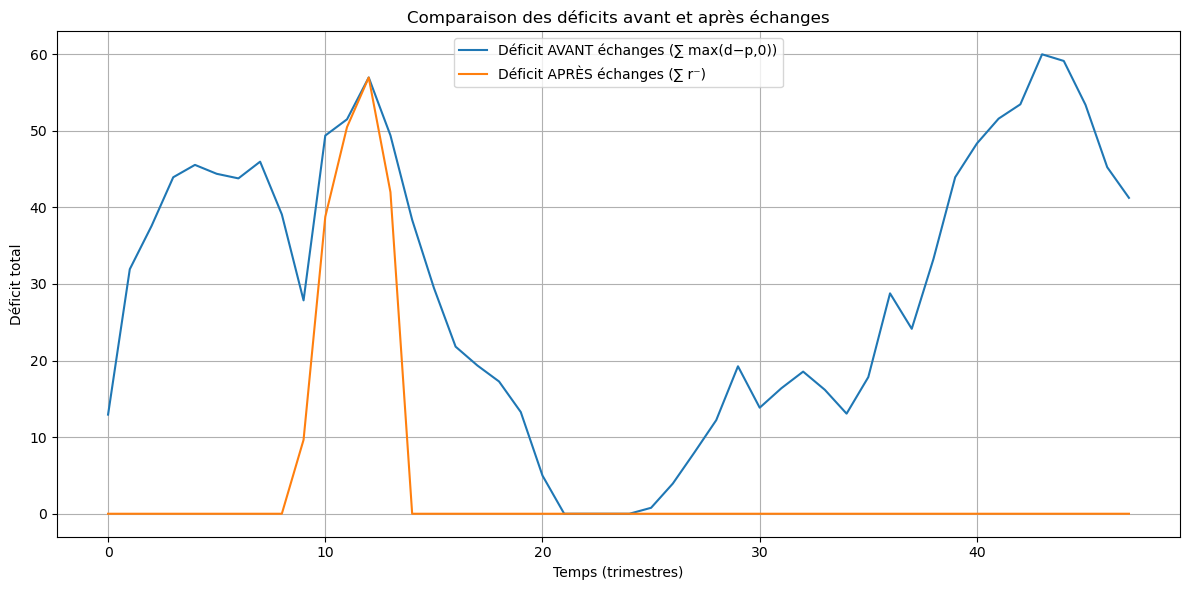

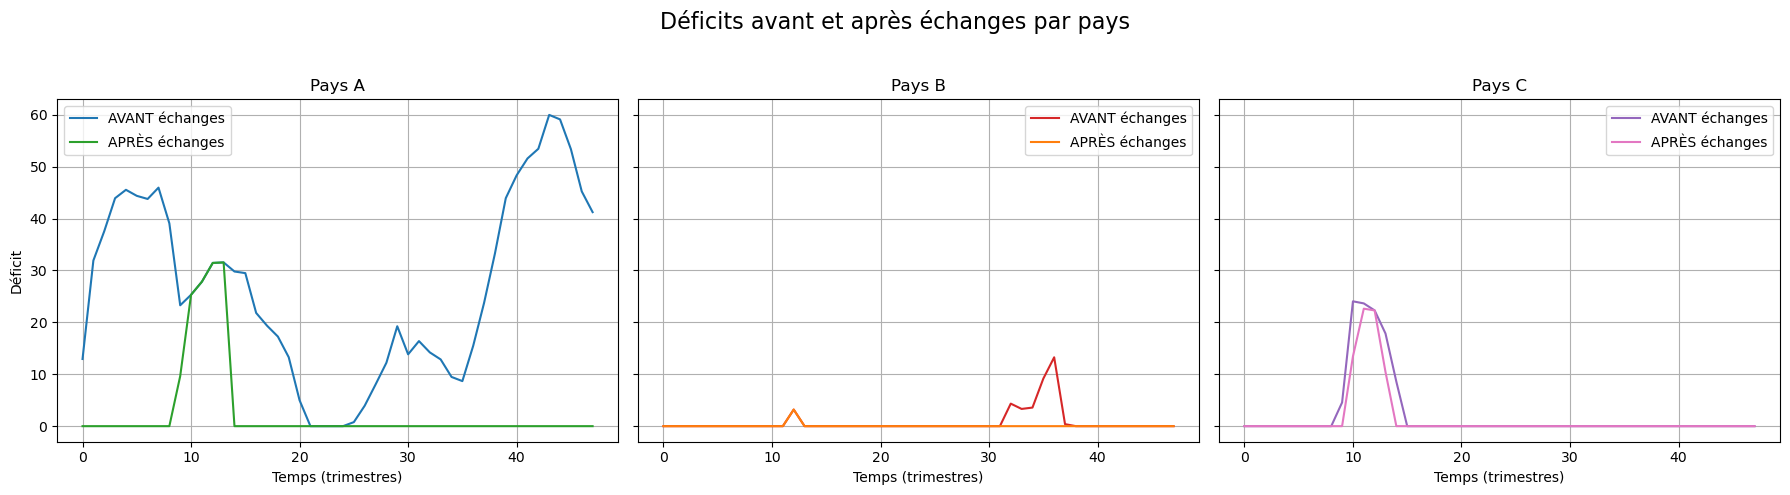

In [94]:
# r_neg est déjà une matrice (T, N)
r_neg_sum = np.sum(r_neg, axis=1)  # somme par ligne → déficit total après échanges

# Déficit avant échanges
raw_deficit = np.maximum(dem - prod, 0)
raw_deficit_sum = np.sum(raw_deficit, axis=1)  # somme par ligne → déficit total avant échanges

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(raw_deficit_sum, label="Déficit AVANT échanges (∑ max(d−p,0))")
plt.plot(r_neg_sum, label="Déficit APRÈS échanges (∑ r⁻)")


plt.title("Comparaison des déficits avant et après échanges")
plt.xlabel("Temps (trimestres)")
plt.ylabel("Déficit total")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

pays_labels = ["A", "B", "C"]
couleurs_avant = ["tab:blue", "tab:red", "tab:purple"]
couleurs_apres = ["tab:green", "tab:orange", "tab:pink"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 1 ligne, 3 colonnes

for i, ax in enumerate(axes):

    ax.plot(np.maximum(dem[:, i] - prod[:, i], 0), color=couleurs_avant[i], label="AVANT échanges")
    ax.plot(r_neg[:, i], color=couleurs_apres[i], label="APRÈS échanges")

    ax.set_title(f"Pays {pays_labels[i]}")
    ax.set_xlabel("Temps (trimestres)")
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Déficit")
    ax.legend()

plt.suptitle("Déficits avant et après échanges par pays", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.show()



Graphes orienté des flux sur la période T:

In [95]:
def compute_static_pos(qmax_matrix):
    N = qmax_matrix.shape[0]
    G = nx.DiGraph()

    # Création structure graphique
    for i in range(N):
        G.add_node(i)
    for i in range(N):
        for j in range(N):
            if i != j and qmax_matrix[i, j] > 0:
                G.add_edge(i, j)

    return nx.spring_layout(G, seed=42)


def show_graphs(prod_matrix, demand_matrix, qmax_matrix,
                q_array, r_pos_array, r_neg_array,
                pos, period=0):

    T, N = prod_matrix.shape

    # ===== 1️⃣ Graphe Capacités qmax =====
    G1 = nx.DiGraph()
    Q = prod_matrix[period] - demand_matrix[period]

    for i in range(N):
        G1.add_node(i, Q=Q[i])
    for i in range(N):
        for j in range(N):
            if i != j and qmax_matrix[i, j] > 0:
                G1.add_edge(i, j, qmax=qmax_matrix[i, j])

    node_colors1 = ['green' if Q[i] >= 0 else 'red' for i in G1.nodes()]
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Taille des arêtes FIXE
    nx.draw(G1, pos, ax=axes[0], node_color=node_colors1,
            node_size=1500, width=2, edge_color='gray',
            arrowsize=20)

    # Labels noeuds
    labels1 = {i: f"P{i}\nQ={Q[i]:.1f}" for i in G1.nodes()}
    nx.draw_networkx_labels(G1, pos, labels=labels1, font_size=10, ax=axes[0])

    # Labels arêtes qmax
    edge_labels1 = {(i, j): f"{G1.edges[i, j]['qmax']:.1f}" for i, j in G1.edges()}
    nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels1, font_size=9, ax=axes[0])

    axes[0].set_title(f"Capacités qmax - Période {period}")


    # ===== 2️⃣ Graphe flux réels =====
    G2 = nx.DiGraph()
    for i in range(N):
        r = r_pos_array[period, i] - r_neg_array[period, i]
        G2.add_node(i, r=r)
    for i in range(N):
        for j in range(N):
            v = q_array[period, i, j]
            if i != j and v > 1e-6:
                G2.add_edge(i, j, flux=v)

    node_colors2 = ['green' if G2.nodes[i]['r'] >= 0 else 'red' for i in G2.nodes()]
    nx.draw(G2, pos, ax=axes[1], node_color=node_colors2,
            node_size=1500, width=2,
            edge_color='blue', arrowsize=20)

    labels2 = {i: f"P{i}\nr={G2.nodes[i]['r']:.2f}" for i in G2.nodes()}
    nx.draw_networkx_labels(G2, pos, labels=labels2, font_size=10, ax=axes[1])

    # Labels arêtes flux
    edge_labels2 = {(i, j): f"{G2.edges[i, j]['flux']:.2f}" for i, j in G2.edges()}
    nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels2, font_size=9, ax=axes[1])

    axes[1].set_title("Flux optimisés")

    plt.show()



# === Fonction interactive finale ===
def interactive_graphs(prod, dem, qmax, q, r_pos, r_neg):
    pos = compute_static_pos(qmax)
    T = prod.shape[0]

    interact(lambda period: show_graphs(prod, dem, qmax, q, r_pos, r_neg, pos, period),
             period=IntSlider(min=0, max=T-1, step=1, value=0, description="Temps"))

In [96]:
interactive_graphs(prod, dem, qmax, q, r_pos, r_neg)

interactive(children=(IntSlider(value=0, description='Temps', max=47), Output()), _dom_classes=('widget-intera…